In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

## Read database

In [2]:
dbfile = "os-sqlite3-data/database.db"
table_name = "searched_books"
query = f"SELECT * FROM {table_name}"
with sqlite3.connect(dbfile) as connection:
    df = pd.read_sql_query(query, connection)

In [3]:
df.columns

Index(['id', 'title', 'authors', 'is_found_a', 'is_found_b', 'search_count_a',
       'search_count_b', 'search_terms_a', 'search_terms_b',
       'search_begin_time_utc', 'found_time_utc_a', 'found_time_utc_b',
       'search_end_time_utc', 'uid'],
      dtype='object')

In [4]:
# Convert missing values and booleans
df.replace("undefined", None, inplace=True)
df[["is_found_a", "is_found_b"]] = df[["is_found_a", "is_found_b"]].replace(
    "true", True
)  # , inplace=True)
df[["is_found_a", "is_found_b"]] = df[["is_found_a", "is_found_b"]].replace(
    "false", False
)  # , inplace=True)

# Convert timestamps in string format to datetime
df["search_begin_time_utc"] = pd.to_datetime(df["search_begin_time_utc"])
df["search_end_time_utc"] = pd.to_datetime(df["search_end_time_utc"])
df["found_time_utc_a"] = pd.to_datetime(df["found_time_utc_a"])
df["found_time_utc_b"] = pd.to_datetime(df["found_time_utc_b"])

# Calculate durations in seconds
df["search_duration_a"] = (
    df["found_time_utc_a"] - df["search_begin_time_utc"]
).dt.total_seconds()
df["search_duration_b"] = (
    df["found_time_utc_b"] - df["search_begin_time_utc"]
).dt.total_seconds()
df["duration_to_proceed"] = (
    df["search_end_time_utc"] - df["search_begin_time_utc"]
).dt.total_seconds()

df.head()

,id,title,authors,is_found_a,is_found_b,search_count_a,search_count_b,search_terms_a,search_terms_b,search_begin_time_utc,found_time_utc_a,found_time_utc_b,search_end_time_utc,uid,search_duration_a,search_duration_b,duration_to_proceed
0,1,Viltti ja Vanu varovaisten talossa,"Skyttä-Forssell, Jenni",True,True,1,1,"kissa,","kissa,",2023-10-06 09:18:14.205000+00:00,2023-10-06 09:18:19.291000+00:00,2023-10-06 09:18:22.565000+00:00,2023-10-06 09:18:23.848000+00:00,8690f5da-898c-45d8-b88c-e3da30eab6b2,5.086,8.360,9.643
1,2,Lastensairaala,"Eidem, Karl; Poljarevius, Jale",True,True,3,5,"terroristit,","sairaalat,",2023-10-06 11:27:13.550000+00:00,2023-10-06 11:27:57.977000+00:00,2023-10-06 11:28:31.789000+00:00,2023-10-06 11:28:32.845000+00:00,8690f5da-898c-45d8-b88c-e3da30eab6b2,44.427,78.239,79.295
2,3,Juha Mats,,False,False,None,None,None,None,2023-10-06 11:28:41.177000+00:00,NaT,NaT,2023-10-06 11:29:19.440000+00:00,8690f5da-898c-45d8-b88c-e3da30eab6b2,NaN,NaN,38.263
3,4,Pimeä kuu,,False,False,None,None,None,None,2023-10-06 11:30:46.184000+00:00,NaT,NaT,2023-10-06 11:32:13.136000+00:00,8690f5da-898c-45d8-b88c-e3da30eab6b2,NaN,NaN,86.952
4,5,Veikko tahtoo ulos,"Erämaja, Anja",True,False,1,None,"koira, yksinolo,",None,2023-10-06 13:16:40.370000+00:00,2023-10-06 13:16:51.621000+00:00,NaT,2023-10-06 13:18:06.768000+00:00,8690f5da-898c-45d8-b88c-e3da30eab6b2,11.251,NaN,86.398


# Results (Materiaali ja tuloksia)

## Number of participants 

In [5]:
df["uid"].nunique()

3

## Number of books searched 

In [6]:
df["title"].nunique()

25

## Number of searches

In [7]:
len(df)

30

# Results (Table A vs B)

In [8]:
df[
    [
        "is_found_a",
        "is_found_b",
    ]
].sum().to_frame(name="Successful searches sum").T

,is_found_a,is_found_b
Successful searches sum,21,12


In [9]:
df[
    [
        "is_found_a",
        "is_found_b",
    ]
].mean().to_frame(
    name="Successful searches share"
).T * 100  # to percentage

,is_found_a,is_found_b
Successful searches share,70.0,40.0


In [10]:
# search_count_X is the number of searches performed when a book is selected
df[
    [
        "search_count_a",
        "search_count_b",
        "search_duration_a",
        "search_duration_b",
    ]
].mean().to_frame().T

,search_count_a,search_count_b,search_duration_a,search_duration_b
0,1.761905,2.083333,39.957571,52.428083


In [11]:
# search_count_X is the number of searches performed when a book is selected
df[
    [
        "search_count_a",
        "search_count_b",
        "search_duration_a",
        "search_duration_b",
    ]
].median().to_frame().T

,search_count_a,search_count_b,search_duration_a,search_duration_b
0,2.0,1.0,29.887,32.2215


## Best searcher

In [12]:
dbfile = "os-sqlite3-data/database.db"
table_name = "users"
query = f"SELECT * FROM {table_name}"
with sqlite3.connect(dbfile) as connection:
    df_users = pd.read_sql_query(query, connection)
df_with_users = df.merge(df_users, on="uid")

## The user that found the greatest number of books

In [13]:
df_with_users.groupby(by="user_number")[["is_found_a", "is_found_b"]].sum().sum(
    axis=1
).sort_values(ascending=False).to_frame(name="Number of found books")

,Number of found books
user_number,
3,14
1,13
4,6


In [14]:
# User with most books searched
df_with_users.groupby(by="user_number").size()

user_number
1    15
3    10
4     5
dtype: int64

In [15]:
# User with most individual searches cannot be known (search_count_X is the number of searches performed when a book is selected)

## The user that found books with fewest searches

In [16]:
df_with_users.groupby(by="user_number")[
    ["search_count_a", "search_count_b"]
].mean().mean(axis=1).sort_values().to_frame(
    name="Mean searches count for finding a book"
)

,Mean searches count for finding a book
user_number,
3,1.854167
4,1.875
1,2.083333


## The user that found books fastest

In [17]:
df_with_users.groupby(by="user_number")[
    ["search_duration_a", "search_duration_b"]
].mean().mean(axis=1).sort_values().to_frame(
    name="Mean search duration for finding a book"
)

,Mean search duration for finding a book
user_number,
4,26.410375
1,37.290597
3,63.234021


## TODO Plots?


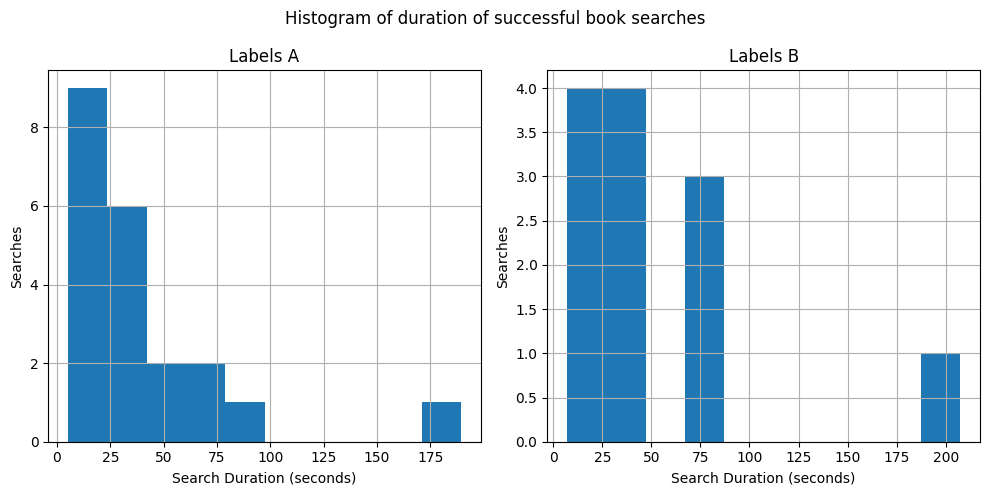

In [18]:
# Create a subplot with two histograms
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
bins = list(range(0, 300, 20))

# Subplot for 'labels_set' == 'a'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
df.search_duration_a.hist()  # bins=bins)
plt.xlabel("Search Duration (seconds)")
plt.ylabel("Searches")
plt.title("Labels A")

# Subplot for 'labels_set' == 'b'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
df.search_duration_b.hist()  # bins=bins)
plt.xlabel("Search Duration (seconds)")
plt.ylabel("Searches")
plt.title("Labels B")

plt.suptitle("Histogram of duration of successful book searches")
plt.tight_layout()  # Adjusts subplot parameters for better spacing
plt.show()

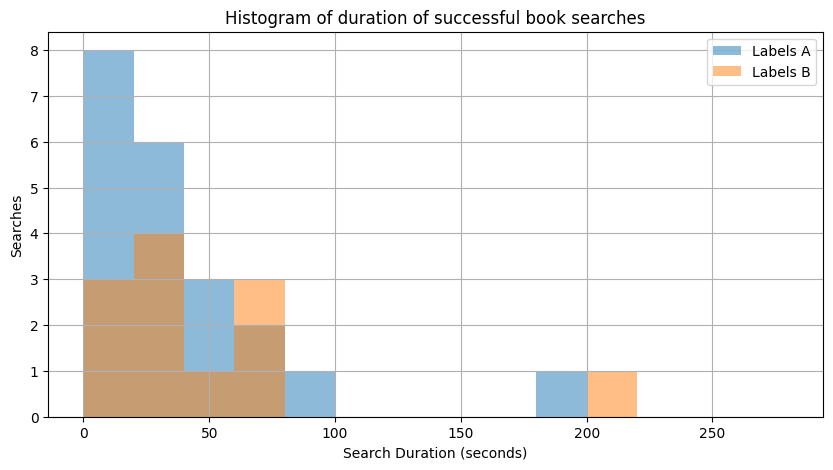

In [19]:
# Create a single histogram with both sets of data
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
bins = list(range(0, 300, 20))

# Plot histogram for 'labels_set' == 'a'
df.search_duration_a.hist(
    bins=bins, alpha=0.5, label="Labels A"
)  # alpha adds transparency

# Plot histogram for 'labels_set' == 'b'
df.search_duration_b.hist(
    bins=bins, alpha=0.5, label="Labels B"
)  # alpha adds transparency

plt.xlabel("Search Duration (seconds)")
plt.ylabel("Searches")
plt.title("Histogram of duration of successful book searches")
plt.legend()  # Add legend to distinguish between 'Labels A' and 'Labels B'
plt.show()

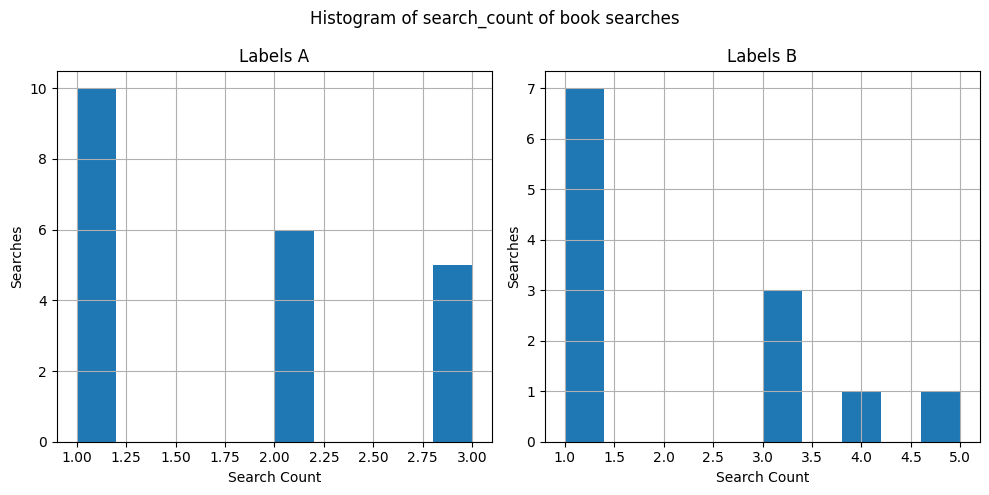

In [20]:
# Create a subplot with two histograms
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
# bins = list(range(0, 300, 20))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
df.search_count_a.hist()  # bins=bins)
plt.xlabel("Search Count")
plt.ylabel("Searches")
plt.title("Labels A")

# Subplot for 'labels_set' == 'b'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
df.search_count_b.hist()  # bins=bins)
plt.xlabel("Search Count")
plt.ylabel("Searches")
plt.title("Labels B")

plt.suptitle("Histogram of search_count of book searches")
plt.tight_layout()  # Adjusts subplot parameters for better spacing
plt.show()

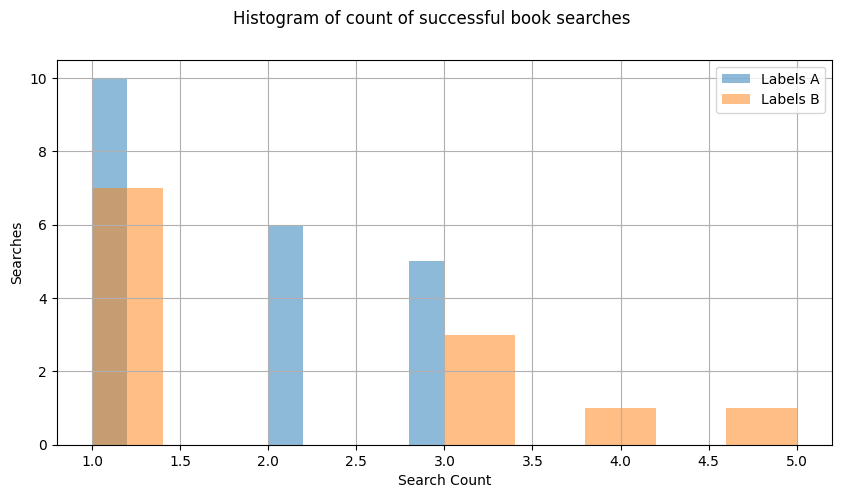

In [21]:
# Create a single histogram with both sets of data
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
bins = None  # list(range(0, 7, 7))

# Plot histogram for 'labels_set' == 'a'
df.search_count_a.hist(
    bins=bins, alpha=0.5, label="Labels A"
)  # alpha adds transparency

# Plot histogram for 'labels_set' == 'b'
df.search_count_b.hist(
    bins=bins, alpha=0.5, label="Labels B"
)  # alpha adds transparency

plt.xlabel("Search Count")
plt.ylabel("Searches")
plt.suptitle("Histogram of count of successful book searches")
plt.legend()  # Add legend to distinguish between 'Labels A' and 'Labels B'
plt.show()

## Easiest books to find

Text(0.5, 0, 'Löytöjen määrä')

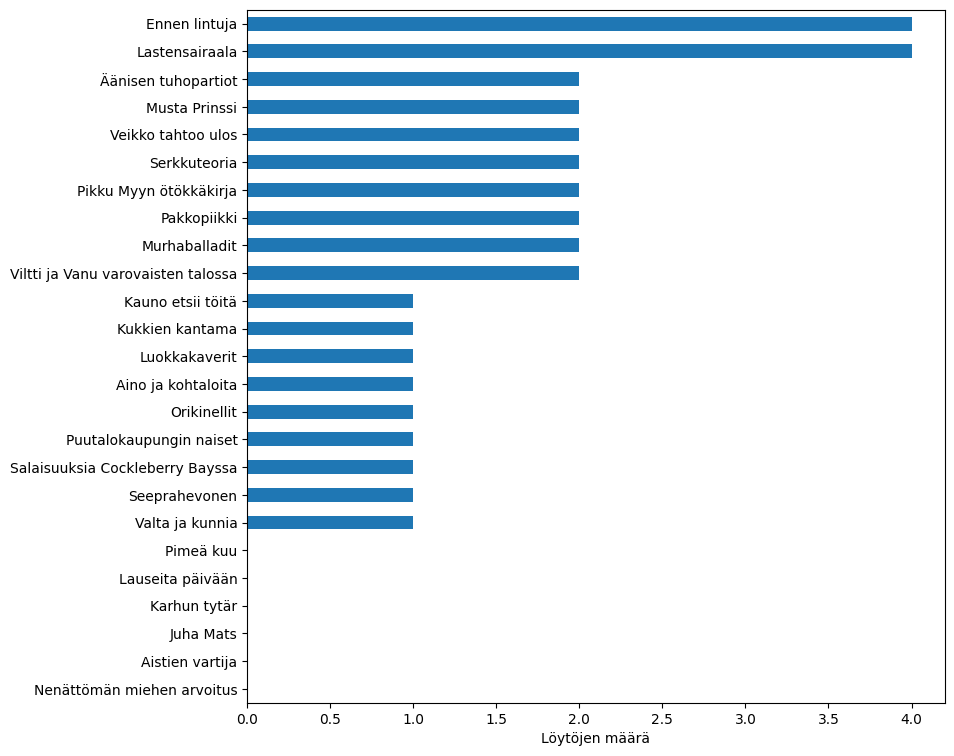

In [90]:
# Altogether, with Kirjasampo & Annif subjects
col = ["is_found_a", "is_found_b"]
df.groupby(by="title")[col].sum().sum(axis=1).sort_values(ascending=True).to_frame(
    name="Found times"
).plot.barh(figsize=(9, 9), legend=False)
plt.ylabel(None)
plt.xlabel("Löytöjen määrä")

Text(0.5, 0, 'Löytöjen määrä')

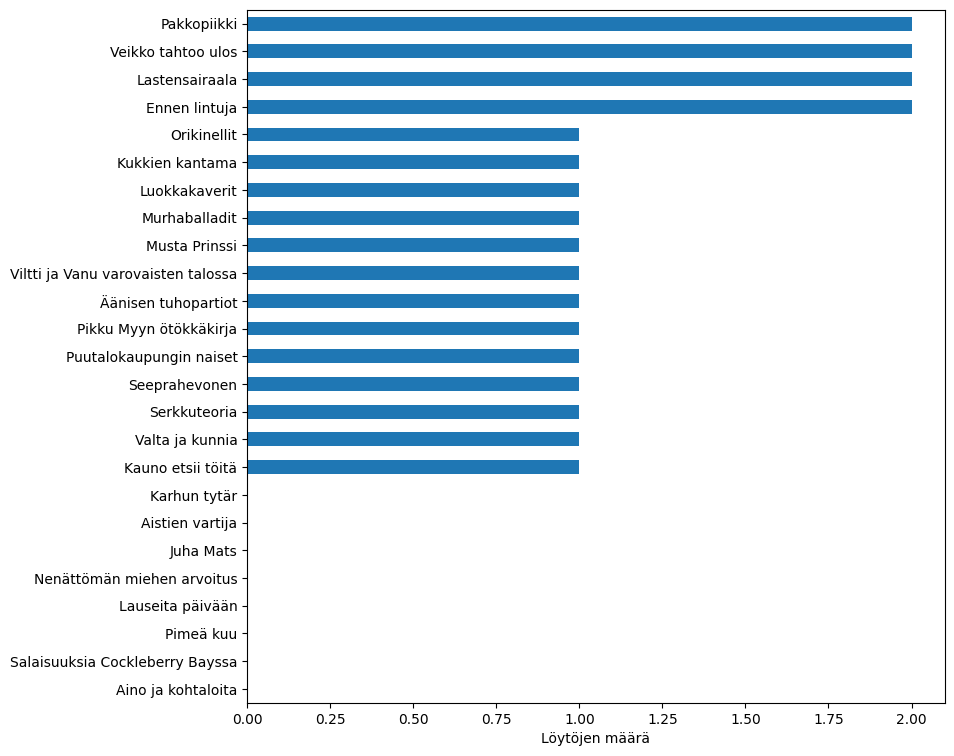

In [101]:
# With Kirjasampo
col = "is_found_a"
df.groupby(by="title")[col].sum().sort_values().to_frame().plot.barh(
    figsize=(9, 9), legend=False
)
plt.ylabel(None)
plt.xlabel("Löytöjen määrä")
# plt.grid(axis='x')

Text(0.5, 0, 'Löytöjen määrä')

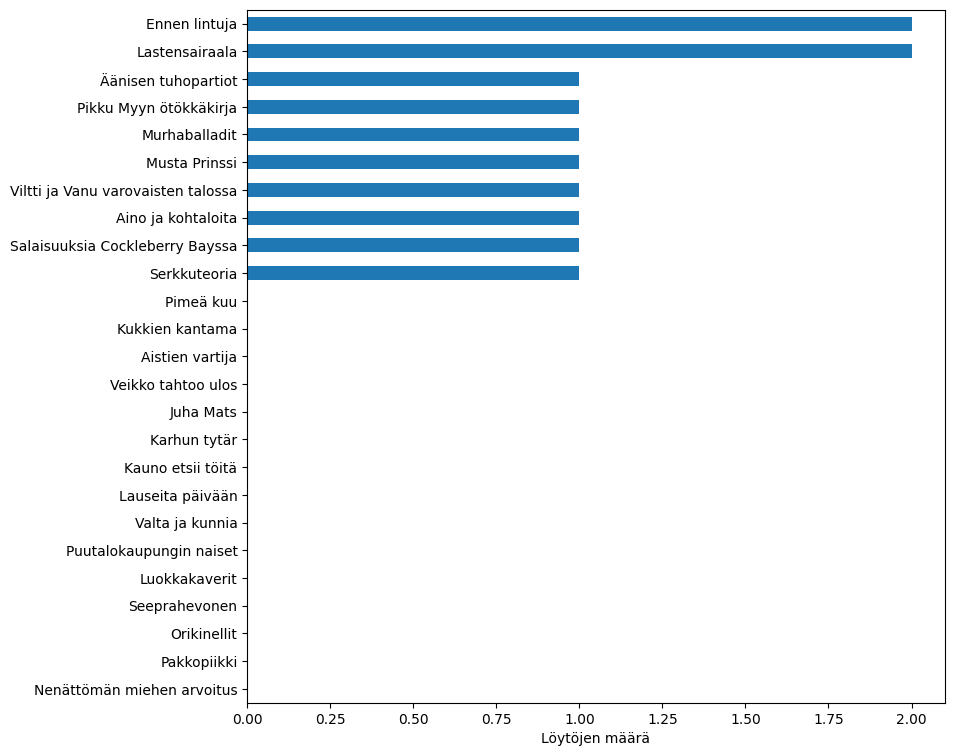

In [102]:
# With Annif subjects
col = "is_found_b"
df.groupby(by="title")[col].sum().sort_values().to_frame().plot.barh(
    figsize=(9, 9), legend=False
)
plt.ylabel(None)
plt.xlabel("Löytöjen määrä")
# plt.grid(axis='x')

Text(0.5, 0, 'Löytöjen määrä, Annif - Kirjasampo')

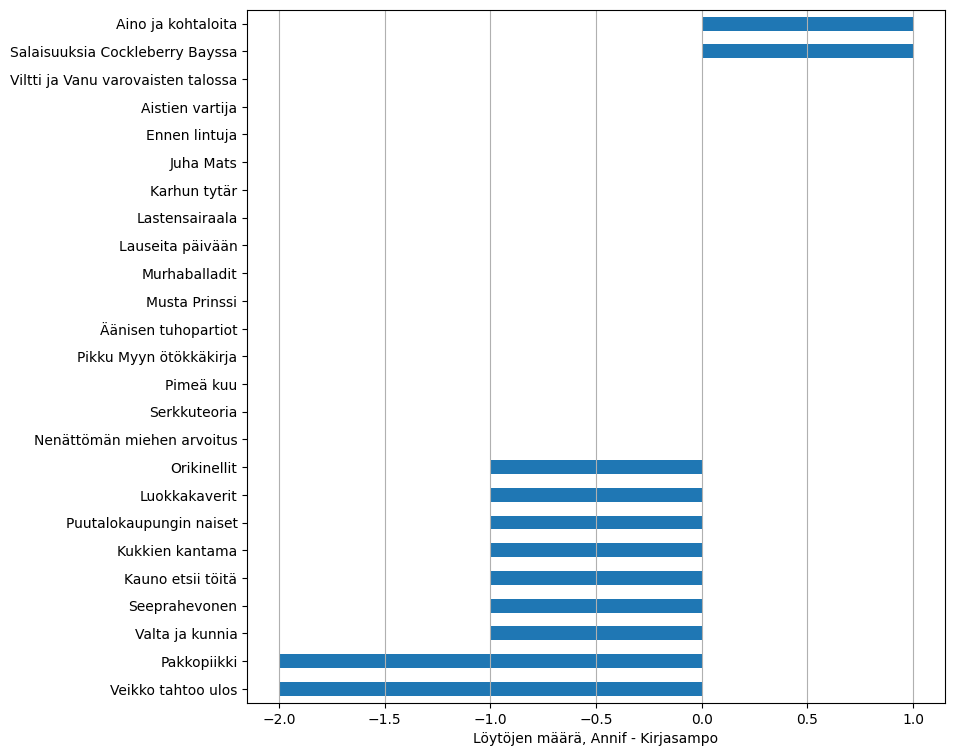

In [104]:
# Difference
diff["difference"] = (
    df.groupby(by="title")[
        [
            "is_found_a",
            "is_found_b",
        ]
    ]
    .sum()
    .diff(axis=1)
    .iloc[:, 1]
)
diff["difference"].sort_values().to_frame().plot.barh(figsize=(9, 9), legend=False)
plt.grid(axis="x")
plt.ylabel(None)
plt.xlabel("Löytöjen määrä, Annif - Kirjasampo")

In [ ]:
import seaborn as sns

df.groupby(by="title")[
    [
        "is_found_a",
        "is_found_b",
    ]
].sum().sort_values(
    by="is_found_a", ascending=False
).plot.scatter(x="is_found_a", y="is_found_b")

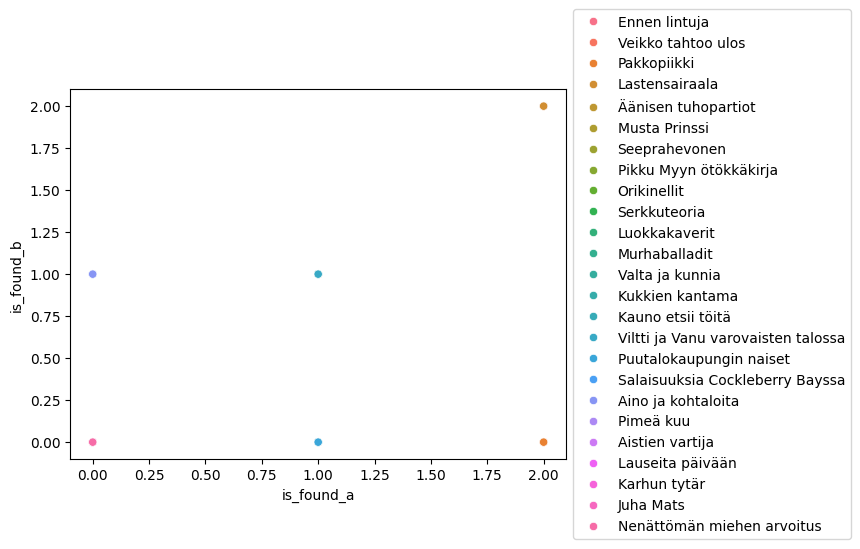

In [45]:
dft = (
    df.groupby(by="title")[
        [
            "is_found_a",
            "is_found_b",
        ]
    ]
    .sum()
    .sort_values(by="is_found_a", ascending=False)
)
sns.scatterplot(data=dft, x="is_found_a", y="is_found_b", hue="title")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))